# Assignment 2 - Question 2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

In [2]:
np.random.seed(7)

In [4]:
def hw2q2():
    Ntrain = 100
    data = generateData(Ntrain)
    plot3(data[0, :], data[1, :], data[2, :])
    xTrain = data[0:2, :]
    yTrain = data[2, :]

    Ntrain = 1000
    data = generateData(Ntrain)
    plot3(data[0, :], data[1, :], data[2, :])
    xValidate = data[0:2, :]
    yValidate = data[2, :]

    return xTrain, yTrain, xValidate, yValidate


def generateData(N):
    gmmParameters = {}
    gmmParameters["priors"] = [0.3, 0.4, 0.3] 
    gmmParameters["meanVectors"] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])
    gmmParameters["covMatrices"] = np.zeros((3, 3, 3))
    gmmParameters["covMatrices"][:, :, 0] = np.array(
        [[1, 0, -3], [0, 1, 0], [-3, 0, 15]]
    )
    gmmParameters["covMatrices"][:, :, 1] = np.array(
        [[8, 0, 0], [0, 0.5, 0], [0, 0, 0.5]]
    )
    gmmParameters["covMatrices"][:, :, 2] = np.array(
        [[1, 0, -3], [0, 1, 0], [-3, 0, 15]]
    )
    x, labels = generateDataFromGMM(N, gmmParameters)
    return x


def generateDataFromGMM(N, gmmParameters):
    #    N vector samples are generateed from specified mixture of Gaussians
    #    Returns samples, their respective component labels
    #    Data dimensionality is determined by the size of mu/Sigma parameters
    priors = gmmParameters["priors"]  # priors should be a row vector
    meanVectors = gmmParameters["meanVectors"]
    covMatrices = gmmParameters["covMatrices"]
    n = meanVectors.shape[0]  # Data dimensionality
    C = len(priors)  # total number of componets
    x = np.zeros((n, N))
    labels = np.zeros((1, N))
    # Decide randomly which samples will come from each component
    u = np.random.random((1, N))
    thresholds = np.zeros((1, C + 1))
    thresholds[:, 0:C] = np.cumsum(priors)
    thresholds[:, C] = 1
    for l in range(C):
        indl = np.where(u <= float(thresholds[:, l]))
        Nl = len(indl[1])
        labels[indl] = (l + 1) * 1
        u[indl] = 1.1
        x[:, indl[1]] = np.transpose(
            np.random.multivariate_normal(meanVectors[:, l], covMatrices[:, :, l], Nl)
        )

    return x, labels


def plot3(a, b, c, mark="o", col="b"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(a, b, c, marker=mark, color=col)
    ax.set_xlabel("axis x1")
    ax.set_ylabel("axis x2")
    ax.set_zlabel("axis y")
    ax.set_title("Dataset (Training)")

In [5]:
def c(x, w):
    x1, x2 = x[0], x[1]
    return (
        w[0]
        + w[1] * x1
        + w[2] * x1**2
        + w[3] * x1**3
        + w[4] * x2
        + w[5] * x2**2
        + w[6] * x2**3
    )


def likelihood(w, x_data, y_data, sigma):
    predictions = np.array([c(x, w) for x in x_data.T])
    return 0.5 * np.sum(((y_data - predictions) ** 2) / sigma**2)


def prior(w, gamma):
    return 0.5 * np.sum(w**2) / gamma


def loss(w, x_data, y_data, sigma, gamma):
    if gamma == np.inf:  # ML case
        return likelihood(w, x_data, y_data, sigma)
    else:  # MAP case
        return likelihood(w, x_data, y_data, sigma) + prior(w, gamma)


def optimize_weights(x_data, y_data, initial_w, sigma, gamma, method):
    result = minimize(
        loss, initial_w, args=(x_data, y_data, sigma, gamma), method=method
    )
    return result.x

C:\Users\keert\AppData\Local\Temp\ipykernel_30376\1157000853.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indl = np.where(u <= float(thresholds[:, l]))


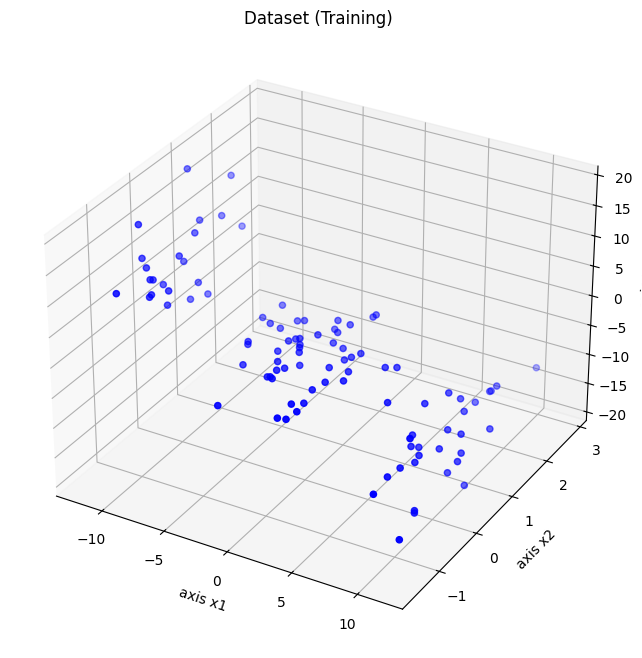

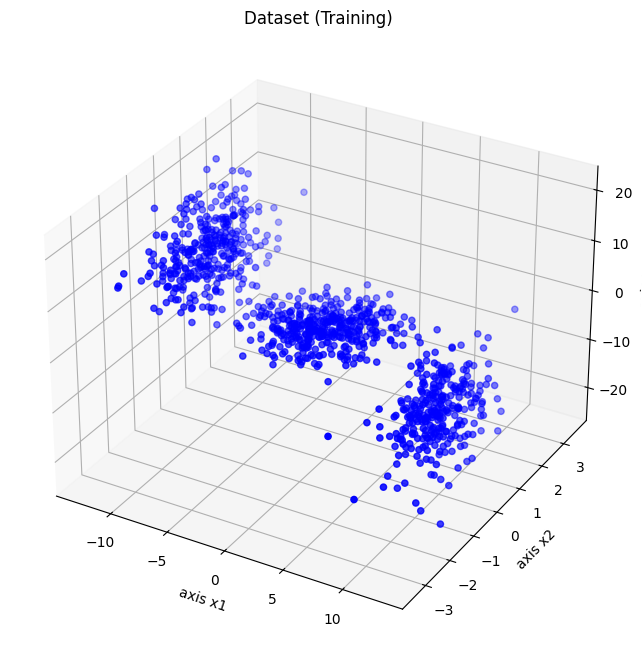

In [6]:
xTrain, yTrain, xValidate, yValidate = hw2q2()
initial_w = np.zeros(7)
sigma = 1.0
gamma_values = np.logspace(-6, 6, 25)

w_ml = optimize_weights(xTrain, yTrain, initial_w, sigma, np.inf, "Nelder-Mead")
ml_mse = np.mean((yValidate - np.array([c(x, w_ml) for x in xValidate.T])) ** 2)

w_map_values = []
mse_values = []

for gamma in gamma_values:
    w_map = optimize_weights(xTrain, yTrain, initial_w, sigma, gamma, "Nelder-Mead")
    w_map_values.append(w_map)

    predictions = np.array([c(x, w_map) for x in xValidate.T])
    mse = np.mean((yValidate - predictions) ** 2)
    mse_values.append(mse)

In [10]:
print("ML Estimator MSE:", ml_mse)
print("Weights:", w_ml)

print("\n MAP Result:")
best_idx = np.argmin(mse_values)
print(f"Gamma: {gamma_values[best_idx]}")
print(f"MSE: {mse_values[best_idx]}")
print("Weights:", w_map_values[best_idx])

ML Estimator MSE: 4.732640959794647
Weights: [-0.00808432 -0.00364884 -0.0053063  -0.01016564  0.00572839  0.0142112
  0.00217902]

 MAP Result:
Gamma: 1e-06
MSE: 4.532484113247531
Weights: [-1.10025155e-04  3.67557607e-04 -2.10456603e-03 -1.00414793e-02
  3.69224912e-05  7.22961845e-06  8.74016703e-05]


In [11]:
print(
    f"MSE at {gamma_values[0]}, 10^-6: {mse_values[0]}\nMSE at {gamma_values[-1]}, 10^+6: {mse_values[-1]}"
)

MSE at 1e-06, 10^-6: 4.532484113247531
MSE at 1000000.0, 10^+6: 4.732640959794647


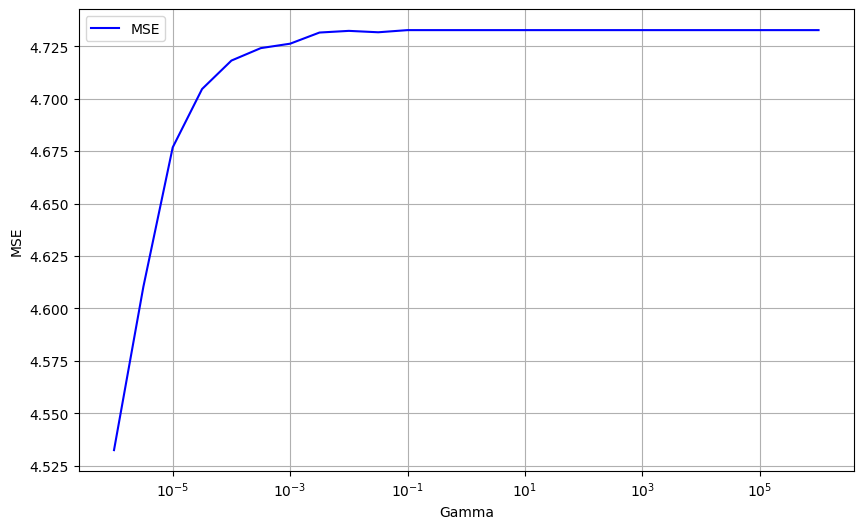

In [12]:
# Plot results
plt.figure(figsize=(10, 6))
plt.semilogx(gamma_values, mse_values, "b-", label="MSE")
plt.grid(True)
plt.xlabel("Gamma")
plt.ylabel("MSE")
plt.legend()
plt.show()